## Imports

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io
import itertools as it
import scipy.special as psi
plt.style.use('classic')
import seaborn as sns
import pandas as pd
import math
import time

from scipy.io import loadmat
from scipy import stats
from numpy.random import seed
from numpy.random import rand
from scipy.integrate import quad
from scipy.io import savemat
from tempfile import TemporaryFile
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.decomposition import KernelPCA
from mpl_toolkits import mplot3d
# from mPE_fn import mPE
from scipy.spatial import distance
from scipy.stats import entropy

## Load Data

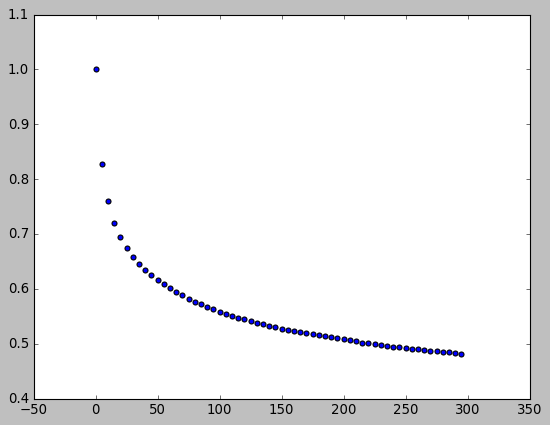

In [2]:
# Get optimal time lag
filename = '/rds/general/user/lr4617/home/4th_Year_Project/CAPTURE_rat_multidimensional/raw_data/normal/traj_1/na_auto_MI_per_lag_6.npy'
sub_sampling = np.load(filename)
step = 5
shifts = step*np.arange(sub_sampling.shape[0])
plt.scatter(shifts, sub_sampling/np.max(sub_sampling))

auto_mi = 0.6*np.max(sub_sampling)
time_lags = np.where(np.isclose(sub_sampling, auto_mi, rtol=1e-02, atol=1e-02))
time_lag = shifts[time_lags[0][0]]

# load entire high-dimensional trajectory
path = '/rds/general/user/lr4617/home/4th_Year_Project/CAPTURE_rat_multidimensional/raw_data/normal/traj_1/trajectories_na/'
trajectories = os.listdir(path)

## Data Cleansing

In [3]:
# removing invalid values (e.g. NaN)
# input data is already normalized (z-score) but needs to get rid of non-valued datapoints
nan_cols = []
for i, time_bin in enumerate(trajectories):
    if time_bin != 'behavs':
        trajectory = loadmat(path + time_bin)
        trajectory = trajectory['trajectory'] 
        for i in range(trajectory.shape[1]):
            if np.isnan(trajectory[:, i]).all():
                nan_cols.append(i)

sampling_factor = time_lag
nan_cols = np.asarray(nan_cols)
a = 0

if nan_cols.size > 0:
    if len(np.where(nan_cols==nan_cols[0])[0])*3 == len(nan_cols):
        sampled_trajectories = np.zeros(((trajectory.shape[0]*int(len(trajectories)/sampling_factor)), trajectory.shape[1]-len(nan_cols)))
        all_trajectories = np.zeros((trajectory.shape[0]*int(len(trajectories)), trajectory.shape[1]-len(nan_cols)))
else:
    sampled_trajectories = np.zeros(((trajectory.shape[0]*int(len(trajectories)/sampling_factor)), trajectory.shape[1]))
    all_trajectories = np.zeros((trajectory.shape[0]*int(len(trajectories)), trajectory.shape[1]))

for i, time_bin in enumerate(trajectories):
    if time_bin != 'behavs':
        trajectory = loadmat(path + time_bin)
        trajectory = trajectory['trajectory'] 
        if nan_cols.size > 0:
            trajectory = np.delete(trajectory, nan_cols, 1)
        idx = a*trajectory.shape[0]
        idx_2 = i*trajectory.shape[0]
        all_trajectories[idx_2:idx_2+trajectory.shape[0], 0:sampled_trajectories.shape[1]] = trajectory
        if i % sampling_factor == 0 and sampled_trajectories.shape[0]-idx >= trajectory.shape[0]:
            sampled_trajectories[idx:idx+trajectory.shape[0], 0:sampled_trajectories.shape[1]] = trajectory
            a+=1
            
# convert nan to number when not it is a sparse recurrence (not an entire column)
sampled_trajectories = np.nan_to_num(sampled_trajectories)
all_trajectories = np.nan_to_num(all_trajectories)

print(sampled_trajectories.shape)
print(all_trajectories.shape)

(108000, 60)
(8208000, 60)


## Dimensionality Reduction - PCA

Explained variance for the first 3 PCs:  0.9060168845447271


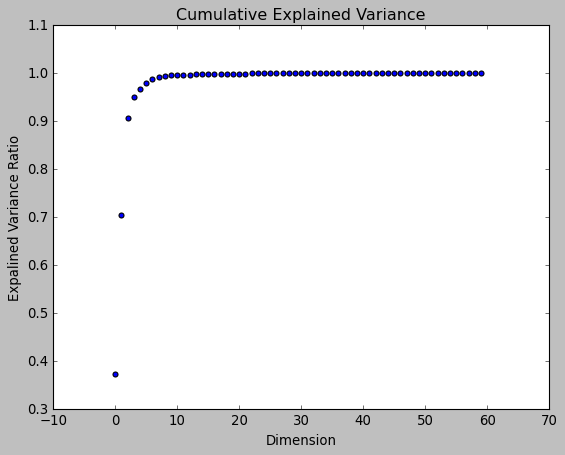

In [4]:
# inspecting inter-dimensional variance with PCA
pca = PCA()
pca.fit(all_trajectories)
explained_var = [np.sum(pca.explained_variance_ratio_[0:i+1]) for i in range(len(pca.explained_variance_ratio_))]
plt.scatter(np.arange(sampled_trajectories.shape[1]), explained_var)
print("Explained variance for the first 3 PCs: ", sum(pca.explained_variance_ratio_[0:3]))
plt.title('Cumulative Explained Variance')
plt.ylabel('Expalined Variance Ratio')
plt.xlabel('Dimension')
plt.show()

## Entropy Analysis

### Helper functions

In [5]:
from scipy.io import savemat
from tempfile import TemporaryFile
import numpy as np
import itertools as it
from scipy.integrate import quad
import math as mt
import scipy.special as psi
import matplotlib.pyplot as plt
plt.style.use('classic')
import seaborn as sns
import pandas as pd
from scipy.io import loadmat
from scipy import stats
from numpy.random import seed
from numpy.random import rand
import matplotlib.gridspec as gridspec

from mPE_ultis import integrand, ubble, array_list, permutation

# [H,h]=mPE(data,n)
# returns the permutation entropy (of order n) and normalised 
# entropy vector of a time series "data"
    
# [H,h]=mPE(data,n,eps)
# returns the permutation entropy (of order n) and normalised 
# entropy vector of a time series "data". The vector eps contains
# as many elements as the number of scales considered by the algorithm.
# Each element of the vector eps represents how many elements are 
# considered in creating a coarse-grained time series. Default is eps=[1]
    
# [H,h]=mPE(data,n,eps,L)
# returns the permutation entropy (of order n) and normalised 
# entropy vector of a time series "data". The vector eps contains
# as many elements as the number of scales considered by the algorithm.
# Each element of the vector eps represents how many elements are 
# considered in creating a coarse-grained time series. Default is eps=[1]
# L is a lag parameter, default is 1.
# 
# n(order of the entropy)
# L(distance between two adjacent elements in the computation)(generally=1)

def mPE_(*argv):    
    g=len(argv)
    
    if g==2:
        n=argv[1]
        datain=argv[0]
        lamin=np.array([1])
        epsin=np.array([1])
    if g==3:
        n=argv[1]
        datain=argv[0]
        lamin=np.array([1])
        epsin=argv[2]
    if g==4:
        n=argv[1]
        datain=argv[0]
        lamin=argv[3]
        epsin=argv[2]
    
#    Check for the data to be in the right dimension
    if len(datain[:,0])>len(datain[0,:]):
        datain=datain.transpose()
        
    scalesno=len(epsin)
    lagno=len(lamin)
    HH=np.zeros((lagno,scalesno))
    norm_HH=np.zeros((lagno,scalesno))
#    Definition of parameters: fac is the number of possible permutations
#    Elem is the No of data points
#    Dim is the dimensionality of the samples
    
    for lam in range(0,lagno):
        for eps in range(0,scalesno):
            scale=epsin[eps]
            L=lamin[lam]
            xlen=len(datain[0,:])
            ylen=np.round((xlen/scale)-0.5)
            ylen=ylen.astype(int)
            D=np.zeros((len(datain[:,0]),ylen))
            for ylenc in range(0,ylen):
                dfg=datain[:,((ylenc)*scale):((ylenc+1)*scale)]
                fhk=np.sum(dfg,axis=1)
                r=(1/scale)*fhk
                D[:,ylenc]=r
                
            data=D
            fac=mt.factorial(n)
            elem=len(data[0,:])
            dim=len(data[:,0])
            
        #    A is a n-by-factorial(n) matrix that shows all the 
        #    possible permutations of n elements
            A=permutation(n)
            
        #    counter is a factorial(n) square matrix that counts the recurrence of
        #    a dim-dimensional permutation
            lpi=fac*np.ones((dim))
            lpi=lpi.astype(int)
            nj = lpi.tolist()
            counter=np.zeros((nj))
            
        #    For each iteration i, a series of n points is sampled from the 
        #    data set and the corresponding permutation is identified. 
        #    The counter matrix keeps track of the numiber of times a certain
        #    permutation, or combination of permutations is observed. 
            for i in range(0, elem-n*L+L-1):
                coord=np.zeros((dim))
                for num in range(0,dim):
                    sample=data[num,range(i,i+L*(n),L)]
                    ord=ubble(sample)
                    perm_num=0
                    check_1=1
                    check_2=1
                    
                    while (perm_num<=fac) and (check_2):
                       
                        check_1=1
                        for j in range(0,n-1):
                            if ord[j]!=A[perm_num,j]:
                                check_1=0
                        if check_1:
                            coord[num]=perm_num
                            check_2=0
                            
                        perm_num=perm_num+1
                
                    
                coord=coord.astype(int)
                coord1=tuple(coord)
                counter[coord1]=counter[coord1]+1
                
        #    Once the counter matrix is complete, each element is divided by the
        #    total number of samples to get a empirical probability, and the PE is
        #    computed according to the method described in Schurmann
            
            H=0
            counter1=counter.flatten()
            for iter in range(0,(fac**dim)):
               
                rec=counter1[iter]
                tot=elem-n+1
                
                if rec==0:
                    H=H
                    
                else:
                    I = quad(integrand, 0, 1, args=(rec))
                    I=I[0]
                    coeff=((-1)**rec)*I
                    prob=(rec/tot)*(psi.digamma(tot)-psi.digamma(rec)-coeff)
                    H=H+mt.log2(mt.exp(prob))
                 
        #     The normalised entropy norm_H is computed as well
            norm_H=H/(mt.log2(fac**dim))
            
            HH[lam,eps]=H
            norm_HH[lam,eps]=norm_H
    return [HH,norm_HH]

In [6]:
def probability(sequence, decimals=1):
    '''
    input: 
        - 1D sequence of rv observations-
    return: 
        - probability vector
    '''
    
    if sequence.shape[0] < sequence.shape[1]:
        sequence = np.transpose(sequence)
    
    # round input sequence to avoid sparse probability vector
    sequence = np.round(sequence, decimals)
    unique = np.unique(sequence, axis=0)
    n_triplets = len(unique)
    
    # fill probability vector
    prob_vector = np.zeros((n_triplets, 1))
    for row in sequence:
        occurrences = len(np.where(np.all(np.isclose(sequence, row), axis=1))[0])
        idx = np.where(np.all(np.isclose(unique, row), axis=1))
        if prob_vector[idx[0]] == 0:
            prob_vector[idx[0]] = occurrences/(sequence.shape[0])
    return prob_vector

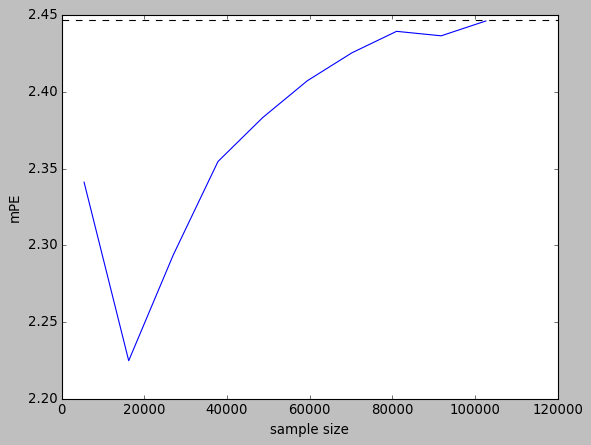

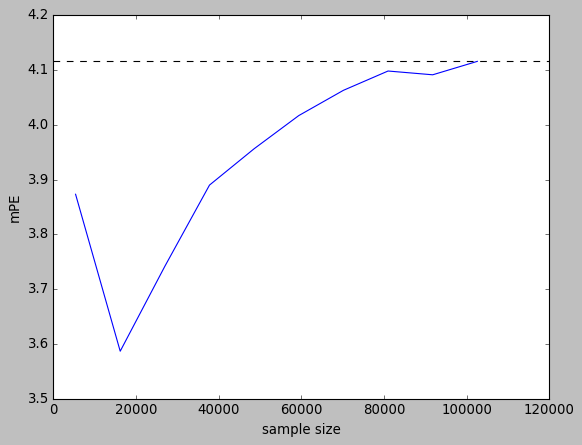

In [9]:
# reduce data according to explained variance values using linear PCA
n_PC = 1
pca = PCA(n_components=n_PC)
reduced_traj = pca.fit_transform(sampled_trajectories)
reduced_traj = [reduced_traj[i][0] for i in range(reduced_traj.size)]
reduced_traj = np.reshape(reduced_traj, (len(reduced_traj), 1))

# sample size effect on dynamical entropy bound
min_portion = 20
orders = [3, 4]
min_length = int(len(reduced_traj)/min_portion)
sizes = np.arange(min_length, len(reduced_traj), 2*min_length)
sample_H = np.zeros((len(orders), sizes.size))
random = False
trials = 20

for i, order in enumerate(orders):
    # calculating entropy bound using the entire trajectory length
    if random:
        rand_uniform_traj = np.random.rand(len(reduced_traj))
        rand_uniform_traj = np.reshape(rand_uniform_traj, (len(reduced_traj), 1))
        [H_bound, _] = mPE_(rand_uniform_traj, order)
    else:
        [H_bound, _] = mPE_(reduced_traj, order)
    for j, size in enumerate(sizes):
        if random:
            valid = False
            while valid==False:
                start_idx = np.random.randint(0, high=len(reduced_traj))
                if start_idx + size <= len(reduced_traj):
                    valid = True
            traj = reduced_traj[start_idx:start_idx + size, :]
        else:
            traj = reduced_traj[0:size, :]
        [H_sample, _] = mPE_(traj, order)
        sample_H[i,j] = H_sample
        
    plt.plot(sizes, sample_H[i,:])
    plt.axhline(y=H_bound, color="black", linestyle="--")
    plt.ylabel('mPE')
    plt.xlabel('sample size')
    plt.show()

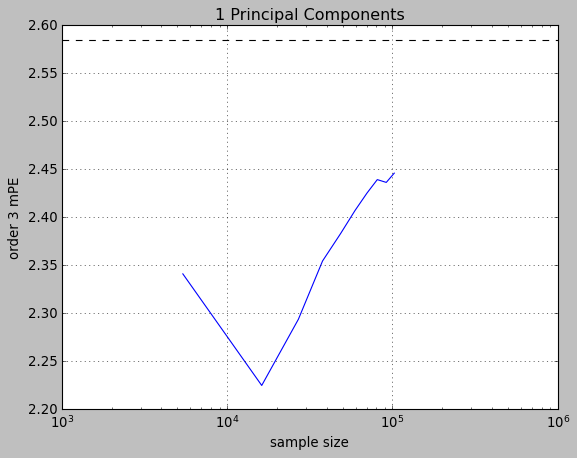

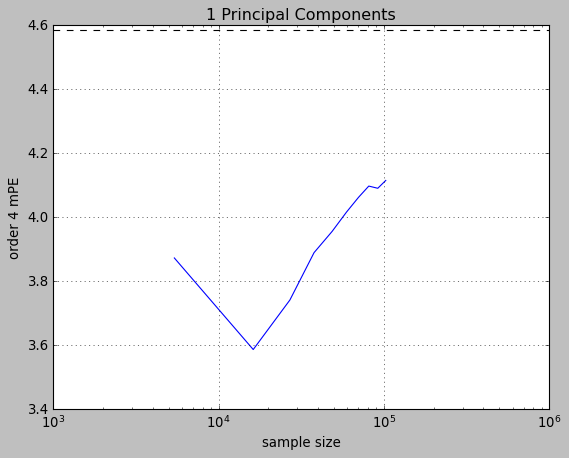

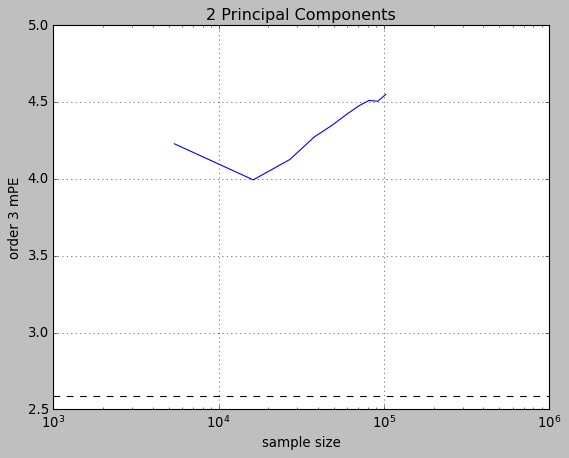

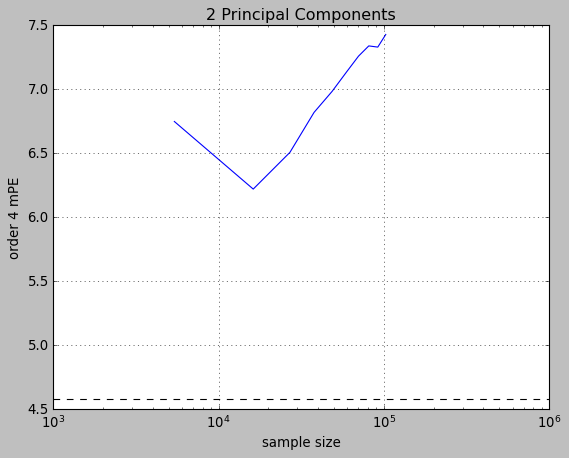

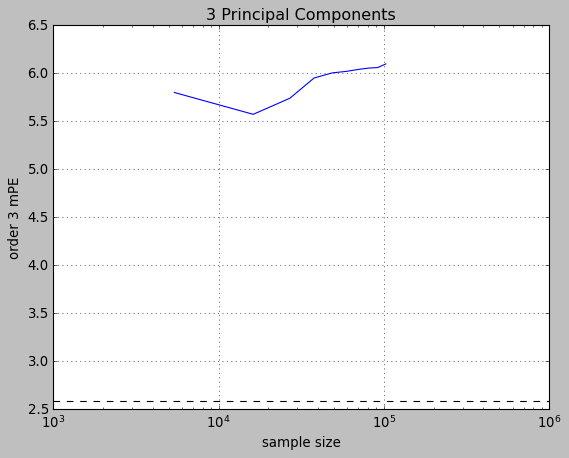

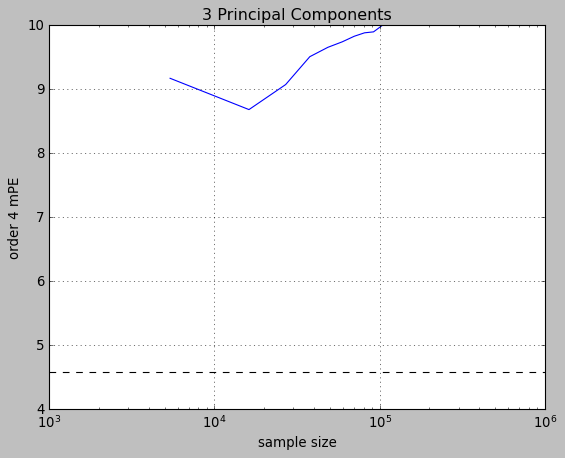

In [22]:
# reduce data according to explained variance values using linear PCA
for trial in range(20):
    for n_PC in range(1,4):
        # TODO: GET EIGENVECTOR
        pca = PCA(n_components=n_PC)
        reduced_traj = pca.fit_transform(sampled_trajectories)
        reduced_traj = np.reshape(reduced_traj, (reduced_traj.shape[0], n_PC))

        # sample size effect on dynamical entropy bound
        min_portion = 20
        orders = [3, 4]
        min_length = int(len(reduced_traj)/min_portion)
        sizes = np.arange(min_length, len(reduced_traj), 2*min_length)
        sample_H = np.zeros((len(orders), sizes.size))
        random = False

        for i, order in enumerate(orders):
            # calculating entropy bound using the entire trajectory length
            if random:
                rand_uniform_traj = np.random.rand(len(reduced_traj))
                rand_uniform_traj = np.reshape(rand_uniform_traj, (len(reduced_traj), n_PC))
                [H_bound, _] = mPE_(rand_uniform_traj, order)
            else:
                # [H_bound, _] = mPE_(reduced_traj, order)
                rand_uniform_traj = np.random.rand(len(reduced_traj))
                rand_uniform_traj = np.reshape(rand_uniform_traj, (len(reduced_traj), n_PC))
                [H_bound, _] = mPE_(rand_uniform_traj, order)

            for j, size in enumerate(sizes):
                if random:
                    valid = False
                    while valid==False:
                        start_idx = np.random.randint(0, high=len(reduced_traj))
                        if start_idx + size <= len(reduced_traj):
                            valid = True
                    traj = reduced_traj[start_idx:start_idx + size, :]
                else:
                    traj = reduced_traj[0:size, :]
                [H_sample, _] = mPE_(traj, order)
                sample_H[i,j] = H_sample

            plt.plot(sizes, sample_H[i,:])
            plt.axhline(y=H_bound, color="black", linestyle="--")
            plt.ylabel('order ' + str(order) + ' mPE')
            plt.xlabel('sample size')
            plt.xscale("log")
            # plt.ylim([np.min(sample_H) - 1 , H_bound + 1])
            plt.title(str(n_PC) + ' Principal Components')
            plt.grid()
            plt.show()

In [31]:
pca = PCA(n_components=1)
reduced_traj = pca.fit_transform(sampled_trajectories)
print(pca.components_.shape)

(1, 60)
